# Test inference notebook using previosly trained and deployed model


In [ ]:
import base64
import json
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, CodeConfiguration, OnlineRequestSettings
#from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, Environment, JobService, Data, CodeConfiguration, OnlineRequestSettings, AmlCompute

from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

## Define global variables

In [2]:
# Deployment
online_endpoint_name = 'srn-endpoint'
registered_model_name = 'custom-model'
deployment_name = 'blue'
inference_env_name = 'inference-env'
request_file_name = 'request.json'

## Create MLClient

In [3]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

ml_client = MLClient.from_config(credential=credential)

Found the config file in: ./config.json


## Connect to the Endpoint

In [4]:
endpoint = ml_client.online_endpoints.get(online_endpoint_name)
print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

Endpoint srn-endpoint provisioning state: Succeeded


## Verify Endpoint traffic and scoring url

In [6]:
# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'blue': 0}
https://srn-endpoint.westeurope.inference.ml.azure.com/score


## Reset traffic for the previous notebook deployment


In [7]:
# blue deployment takes 100 traffic
endpoint.traffic = {deployment_name: 100}
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

Readonly attribute principal_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>
Readonly attribute tenant_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>


ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://srn-endpoint.westeurope.inference.ml.azure.com/score', 'openapi_uri': 'https://srn-endpoint.westeurope.inference.ml.azure.com/swagger.json', 'name': 'srn-endpoint', 'description': 'An online endpoint to generate predictions', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/b7d41fc8-d35d-41db-92ed-1f7f1d32d4d9/resourcegroups/monai-3d-rg/providers/microsoft.machinelearningservices/workspaces/aml-monai-3d/onlineendpoints/srn-endpoint', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/b7d41fc8-d35d-41db-92ed-1f7f1d32d4d9/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oe:6213bfe8-4f3b-4bca-9e8b-941c4ab2f3c0:96e1a681-3721-41e8-b2da-425f93905260?api-version=2022-02-01-preview'}, 'id': '/subscriptions/b7d41fc8-d35d-41db-92ed-1f7f1d32d4d9/resourceGroups/monai-3d-rg/providers/Microsoft.M

## Define validation samples

In [12]:
# Visualization and validation sample
sample_image = '../samples/BraTS2021_00402_flair.nii.gz' 
sample_image_t1 = '../samples/BraTS2021_00402_t1.nii.gz'
sample_image_t1ce = '../samples/BraTS2021_00402_t1ce.nii.gz'
sample_image_t2 = '../samples/BraTS2021_00402_t2.nii.gz'
sample_label = '../samples/BraTS2021_00402_seg.nii.gz'

## Encode validation images and create .json request file

In [13]:
# Encode input images for JSON request file
with open(sample_image, "rb") as image_file:
    flair_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1, "rb") as image_file:
    t1_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1ce, "rb") as image_file:
    t1ce_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t2, "rb") as image_file:
    t2_encoded = base64.b64encode(image_file.read()).decode('utf-8')

request_data = {
    "data": [{"flair": flair_encoded, "t1": t1_encoded, 
              "t1ce": t1ce_encoded, "t2": t2_encoded
             }]
}

# Write the JSON request data to a file
with open(request_file_name, "w") as outfile:
    json.dump(request_data, outfile)

## Send the request and get the responce from Endpoint

In [14]:
response = ml_client.online_endpoints.invoke(
    endpoint_name= online_endpoint_name,
    deployment_name= deployment_name,
    request_timeout_ms=90000,
    request_file=request_file_name,
)


## Convert the responce to numpy array for visualization

In [15]:
import numpy as np
import matplotlib.pyplot as plt


# convert response to numpy array with dimensions channel, height, width, slice
json_response = json.loads(response)
pred_vol = np.array(json_response)

## Convert labels and to inspect inference results
## like in the first notebook

In [16]:
import torch
from monai.apps import DecathlonDataset
from monai.data import DataLoader, Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, NormalizeIntensityd, MapTransform
from monai.visualize.utils import blend_images

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats 2021 classes:
    label 1 necrotic tumor core (NCR)
    label 2 peritumoral edematous/invaded tissue 
    label 3 is not used in the new dataset version
    label 4 GD-enhancing tumor 
    The possible classes are:
      TC (Tumor core): merge labels 1 and 4
      WT (Whole tumor): merge labels 1,2 and 4
      ET (Enhancing tumor): label 4

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(torch.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 4
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = torch.stack(result, axis=0).float()
        return d

val_transform = Compose(
[
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

data_list = [{'image': sample_image, 'label': sample_label}]
val_ds = Dataset(data=data_list, transform=val_transform)

img_vol = val_ds[0]["image"].numpy()
seg_vol = val_ds[0]["label"].numpy()

## Use ipywidgets plugin to visualize original and predicted images

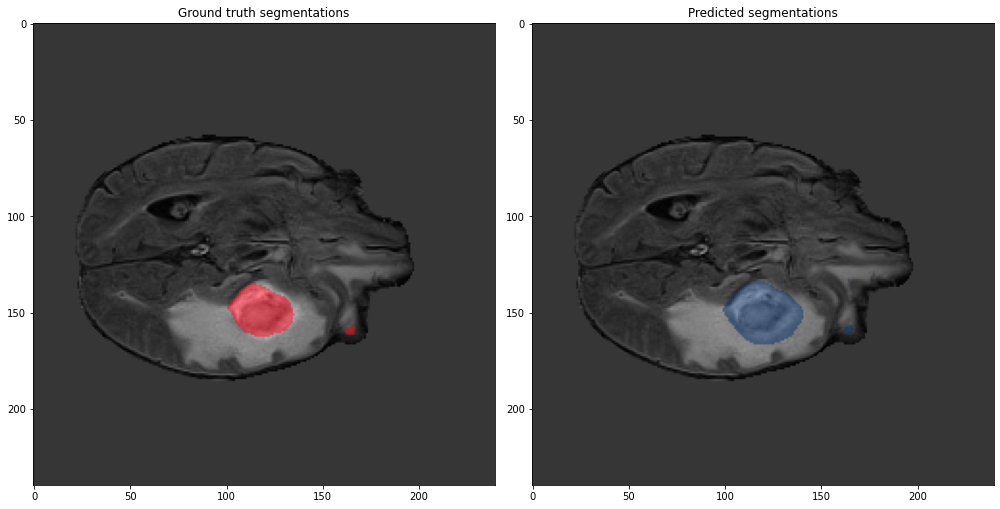

In [17]:
from ipywidgets import interact

def show_slice(slice_index=60):

    img = np.expand_dims(img_vol[0,:,:,slice_index], 0) # images
    true_seg = np.expand_dims(seg_vol[0,:,:,slice_index], 0) # annotated ground truth labels
    pred_seg = np.expand_dims(pred_vol[0,:,:,slice_index], 0)  # predicted labels
    
    blend = blend_images(img, true_seg, cmap='hsv')
    over_true = np.transpose(blend, (1,2,0))
    blend = blend_images(img, pred_seg, cmap='Blues')
    over_pred = np.transpose(blend, (1,2,0))
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 7))

    ax1.imshow(over_true)
    ax1.set_title('Ground truth segmentations')
    ax2.imshow(over_pred)
    ax2.set_title('Predicted segmentations')
    
    plt.tight_layout()
    plt.show()

# Use the interact function to create a slider for the slice index
_ = interact(show_slice, slice_index=(0, img_vol.shape[-1]-1))